# An Introduction to Actuarial Modelling With Heavylight

This page provides a guided walkthrough of how to develop and run an actuarial model using `heavylight`.

## Before you start

- Ensure you have Python 3.8 or newer installed: [Download Python](https://www.python.org/downloads/)
- Install heavylight from [pypi](https://pypi.org/project/heavylight/): `python -m pip install heavylight` or `pip install heavylight`
- If working interactively, install [jupyter lab](https://jupyter.org/install)

Once installed, check libraries are installed, and check the version of heavylight:

In [1]:
import heavylight
import pandas as pd
import numpy as np
print(f"Version: {heavylight.__version__ = }")

Version: heavylight.__version__ = '1.0.6'


## Overview

This document covers the following stages in development and execution of the model:

 - define the model
 - pass in data (or simulate)
 - pass in assumptions
 - run the model
 - viewing the results

In practice, defining, loading data and loading assumptions need to be carried out in parallel, so we will define several iterations of the model (`Model1`, `Model2`...), introducing one concept at a time.  You can skip to the end to see the final iteration of the model.

This guide is designed to give an introduction, so doesn't cover some of the more advanced techniques around performance optimisation (vectorisation using numpy/tensors) or table/model design.

## Define the model

The model is defined as a subclass of `heavylight.Model`, and each value or variable we want to calculate is defined as a method (a function belonging to the class).

In actuarial models we are usually interested in projecting through time, this corresponds to methods with one argument `t`.  When the model is run these are automatically calculated, for each time period specified up to `proj_len`.

`self` is always the first parameter in a python class method.  This allows us to refer to the class instance, including any other data attributes or methods, without passing them into the method separately.

Want to know more about classes?  The python class tutorial can help: https://docs.python.org/3/tutorial/classes.html

In [2]:
class Model1(heavylight.Model):
    def t(self, t):
        """time"""
        return t
    
    def num_alive(self, t):
        """probability that life is alive at time t, given alive at time 0"""
        if t == 0:
            return 1
        else:
            return self.num_alive(t - 1) * 0.99

We can quickly test the model runs by creating an instance of it, and assign it to the variable `model1`.  When an model is instanced, it is run as well, with the variable `proj_len` controlling how many time periods it is run for.  As Python uses zero-indexing this runs from 0, i.e. `proj_len = 5` will calculate for t = 0, 1, 2, 3, 4.

Once the model has run, we can view the results as a dataframe using the `.df` property.

In [3]:
model1 = Model1(proj_len = 5)
model1.df

,t,num_alive
0,0,1.000000
1,1,0.990000
2,2,0.980100
3,3,0.970299
4,4,0.960596


### Exploring the results, and calculating more values

We can see that num alive runs off as expected, 1, 0.99, 0.99^2, 0.99^3...

We can view the values for a variable using `.values`:

In [4]:
model1.num_alive.values

[1, 0.99, 0.9801, 0.9702989999999999, 0.96059601]

Likewise, we can sum up all of them (in this case it's not too meaningful as we aren't looking at cashflows yet!)

In [5]:
model1.num_alive.sum()

4.90099501

We can obtain individual values by calling them with the appropriate parameter (`t` in this case)

In [6]:
model1.num_alive(4)

0.96059601

We can view a dataframe just of the variables results.  This isn't that useful when the function is only dependent on t, however if we have functions with multiple keys such as both `t` and `duration`, then we can view all the output.

In [7]:
model1.num_alive.df

,t,num_alive
0,0,1.000000
1,1,0.990000
2,2,0.980100
3,3,0.970299
4,4,0.960596


Running the projection to time 4 doesn't mean we can't obtain further values, it just means they aren't precomputed (and in extreme cases you may get a recursion limit or stack overflow error).  We can query any value by calling it.

In [8]:
model1.num_alive(20)

0.8179069375972307

This computes all the intermediate values - we can check this in the dataframe.

Note: the variable `t` hasn't been calculated for t > 4, this is because the value of `t` has never been requested for t > 4, as the `t(t)` method isn't called by `num_alive`.

In [9]:
model1.df

,t,num_alive
0,0.0,1.000000
1,1.0,0.990000
2,2.0,0.980100
3,3.0,0.970299
4,4.0,0.960596
5,NaN,0.950990
6,NaN,0.941480
7,NaN,0.932065
8,NaN,0.922745
9,NaN,0.913517


## Passing data to the model

Our model isn't going to be that useful unless we can pass in data, for this model we are interested in the probability of being alive at each valuation point, the probability of dying then, and the expected claim cost arising.  (Sum Assured x Number of Deaths)

We'll add in two new methods, `num_deaths` to count the expected deaths occuring, and `age` to calculate the current age.

`num_deaths` is dependent on the number alive at the start of the period, and the mortality rate `q_x`: as we've not defined a mortality table we'll fudge this for now as being a linear function of age $q_x(t) = 0.001 (x + t)$

For the `age` variable, we want to get this from data at `t = 0` from the field `init_age`.  There are lots of different ways to store and pass in data, for example in a dictionary, using a dataclass, or as individual variables.  For this example we'll use a dictionary, which will be stored in the model as `data`.  We can then query the data field using `self.data["init_age]`.

In [10]:
class Model2(heavylight.Model):
    def t(self, t):
        """time"""
        return t
    
    def num_alive(self, t):
        """probability that life is alive at time t, given alive at time 0"""
        if t == 0:
            return 1
        else:
            return self.num_alive(t - 1) - self.num_deaths(t - 1)     # deaths moved to a separate method
        
    def num_deaths(self, t):
        """number of deaths occuring between time t-1 and t"""
        if t < 0:
            return 0
        else:
            q_x = 0.001 * self.age(t)
            return self.num_alive(t) * q_x

    def age(self, t):
        """age in years at time t"""
        if t == 0:
            return self.data["init_age"]
        elif t % 12 == 0:
            return self.age(t - 1) + 1
        else:
            return self.age(t - 1)

We pass the data in as pass of the model instance creation, using the key `data` means it is accessible as `self.data` within the model, in our case `self.data['init_age']` will  look up init_age in the dictionary and return `32`.

In [11]:
data2 = dict(init_age = 32)
model2 = Model2(data=data2, proj_len=10*12 + 1)
model2.df

,t,age,num_alive,num_deaths
0,0,32,1.000000,0.032000
1,1,32,0.968000,0.030976
2,2,32,0.937024,0.029985
3,3,32,0.907039,0.029025
4,4,32,0.878014,0.028096
...,...,...,...,...
116,116,41,0.013636,0.000559
117,117,41,0.013077,0.000536
118,118,41,0.012541,0.000514
119,119,41,0.012027,0.000493


We've got more data here to look at now, as `.df` outputs a pandas dataframe, we can access all the normal dataframe features, for example `.plot()` gives us access to the plotting interface.

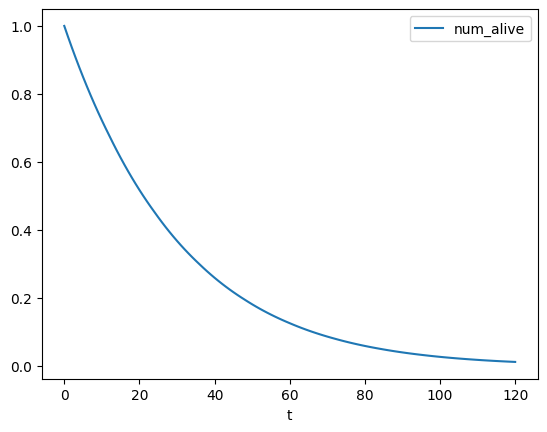

In [12]:
model2.df.plot(x='t', y='num_alive');

## Adding a table to store structured assumptions

Heavylight comes with the `Table` class which is optional, and provides a high performance table capable of handling most actuarial tables, and loading in data from pandas dataframes, Excel, and CSV formats.  See the main Tables documentation for the latest details.

Here we will create a mortality table, rather than loading it it, although in practice most tables will be pre-computed.

We start by creating a dataframe, with ages running from 16 to 130.  The `Table` class needs to know what type the key is, in this case we are using integers, and we want to ensure that the lookup doesn't go past the lower and upper values (so any values under 16 or over 130 will look up 16 or 130 respectively), so we are specifing type `int_bound`.   The overall key is therefore `age|int_bound`.

In [13]:
df_mort = pd.DataFrame(
    {'age|int_bound': range(16, 131)}
)
df_mort

,age|int_bound
0,16
1,17
2,18
3,19
4,20
...,...
110,126
111,127
112,128
113,129


Our table also need values (mortality rates).  Mortality rates are generally exponential, so we'll populate `q_x` using an exponential function - this has just been picked for ease of use:

$q_x = 0.002e^{0.064(x-30)} + 0.001$

We also use `np.clip` to ensure this falls in the range $[0, 1]$ as it is a probability.

In [14]:
# 0.02*2.64**(0.04 * (t + 30)) + 0.002
df_mort['q_x|float'] = 0.002 * np.exp(0.064 * (df_mort['age|int_bound'] - 30)) + 0.001
df_mort['q_x|float'] = np.clip(df_mort['q_x|float'], 0, 1) # ensure between 0 and 1
df_mort

,age|int_bound,q_x|float
0,16,0.001816
1,17,0.001870
2,18,0.001928
3,19,0.001989
4,20,0.002055
...,...,...
110,126,0.932827
111,127,0.994414
112,128,1.000000
113,129,1.000000


Let's check how that looks with a plot:

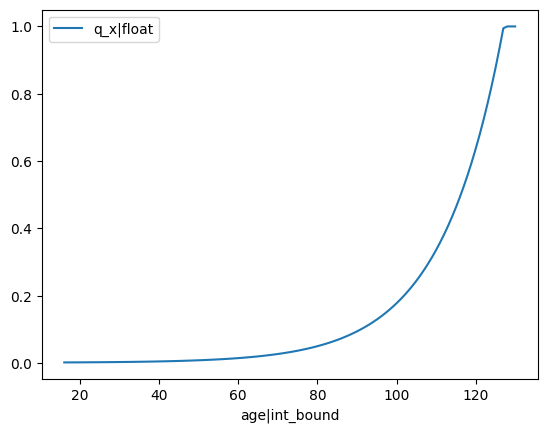

In [15]:
df_mort.plot(x='age|int_bound', y='q_x|float');

This looks fine, so we can create a heavylight `Table` instance using it.

In [16]:
mort_table = heavylight.Table(df_mort)

Tables are looked up based on keys, using the square brackets `[]`, so to get the rate for age 110:

In [17]:
mort_table[110]

0.3356707392422082

## Incorporating the mortality table into the model

We could now create a basis dictionary (much like the data dictionary), however for this case we'll use a small class for the basis.  This will give us the option to use `.item` notation rather than dictionary item lookups `['item']`.  Either approach works.

At the same time as adding the mortality table, let's at a flat discount rate, and precompute the monthly equivalent rate.  Note that power in python is accomplished with the `**` operator, e.g. if we wrote `=2^3` in Excel, the python equivalent would be `2**3`.

Python operators are listed here: https://docs.python.org/3/library/operator.html#mapping-operators-to-functions

In [18]:
class Basis:
    def __init__(self, mort_table, disc_rate_pa):
        self.mort_table = mort_table
        self.disc_rate_pa = disc_rate_pa
        self.disc_rate_pm = (1 + disc_rate_pa) ** (1/12) - 1

We can create a class instance with our specific values, passing in the mortality table (`mort_table`) and a flat discount rate of 4% per annum

In [19]:
basis3 = Basis(mort_table=mort_table, disc_rate_pa = 0.04)
basis3.mort_table[120]

0.6356966578357008

Doing a quick check that the monthly discount rate is calculated:

In [20]:
basis3.disc_rate_pm

0.0032737397821989145

Updating the model to look up the mortality table, the key change is the addition of `q_x` which looks up `self.basis.mort_table`.

In [21]:
class Model3(heavylight.Model):
    def t(self, t):
        """time"""
        return t
    
    def num_alive(self, t):
        """probability that life is alive at time t, given alive at time 0"""
        if t == 0:
            return 1
        else:
            return self.num_alive(t - 1) - self.num_deaths(t - 1)     # deaths moved to a separate method
        
    def num_deaths(self, t):
        """number of deaths occuring between time t-1 and t"""
        if t < 0:
            return 0
        else:
            return self.num_alive(t) * self.q_x(t)

    def q_x(self, t):
        return self.basis.mort_table[self.age(t)]

    def age(self, t):
        """age in years at time t"""
        if t == 0:
            return self.data["init_age"]
        elif t % 12 == 0:
            return self.age(t - 1) + 1
        else:
            return self.age(t - 1)

Running this - picking a longer projection and an older age so we have higher q_x values:

In [22]:
data3 = dict(init_age = 65)

model3 = Model3(data=data3, basis=basis3, proj_len = 361)
model3.df

,t,age,num_alive,num_deaths,q_x
0,0,65,1.000000e+00,1.978666e-02,0.019787
1,1,65,9.802133e-01,1.939515e-02,0.019787
2,2,65,9.608182e-01,1.901139e-02,0.019787
3,3,65,9.418068e-01,1.863521e-02,0.019787
4,4,65,9.231716e-01,1.826648e-02,0.019787
...,...,...,...,...,...
356,356,94,1.289973e-09,1.563432e-10,0.121199
357,357,94,1.133629e-09,1.373945e-10,0.121199
358,358,94,9.962349e-10,1.207425e-10,0.121199
359,359,94,8.754924e-10,1.061086e-10,0.121199


We can plot `age` against `q_x` to check it is broadly exponential:

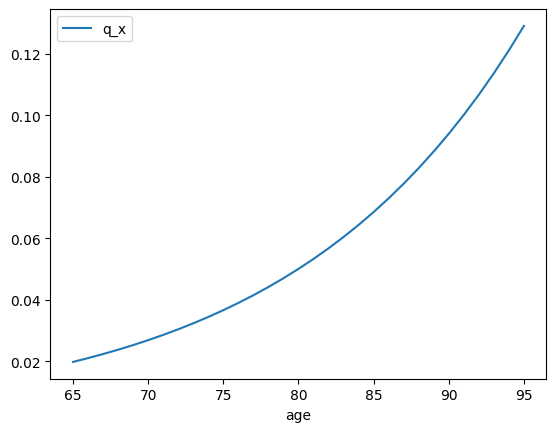

In [23]:
model3.df.plot(x='age', y='q_x');

And likewise, have a look at the pattern of deaths - starting around 0.02, and tailing off.  The saw type pattern is because ages are integer, so the same rate is used for 12 valuation periods.

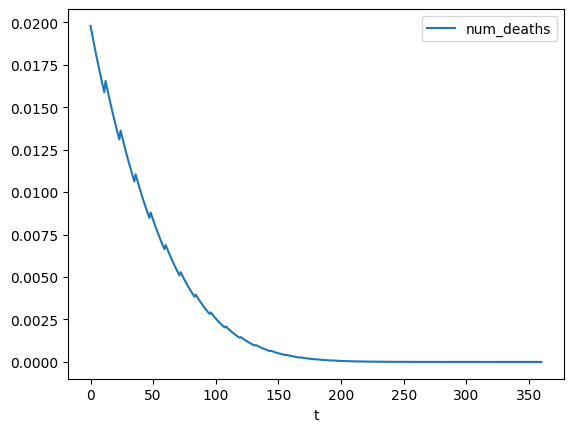

In [24]:
model3.df.plot(x='t', y='num_deaths');

## Adding Cashflows - expected claim, premium and present values

There are a few different ways we can work out present values, we could either pull out cashflows from the model and use a separate `npv()` function, create a discounting model, however for simplicity in this case we'll add a `v` function.  In line with general actuarial practice which uses $v^t$: https://en.wikipedia.org/wiki/Actuarial_present_value

`pv_claim` is an intermediate function, if we take the sum of this, it is the equivalent of Excel `SUMPRODUCT` on the `v` column and the `expected_claim` column.

In [25]:
class Model4(heavylight.Model):
    basis: Basis  # added here to allow code auto-completion
    data: dict

    def t(self, t):
        """time"""
        return t
    
    def num_alive(self, t):
        """probability that life is alive at time t, given alive at time 0"""
        if t == 0:
            return 1
        else:
            return self.num_alive(t - 1) - self.num_deaths(t - 1)     # deaths moved to a separate method
        
    def num_deaths(self, t):
        """number of deaths occuring between time t-1 and t"""
        if t < 0:
            return 0
        else:
            return self.num_alive(t) * self.q_x(t)

    def q_x(self, t):
        return self.basis.mort_table[self.age(t)]

    def age(self, t):
        """age in years at time t"""
        if t == 0:
            return self.data["init_age"]
        elif t % 12 == 0:
            return self.age(t - 1) + 1
        else:
            return self.age(t - 1)
        
    def expected_claim(self, t):
        return self.data["sum_assured"] * self.num_deaths(t)
    
    def v(self, t):
        """Present value factor for time t, discounting back to time 0"""
        if t == 0:
            return 1.0
        else:
            return self.v(t - 1) / (1 + self.basis.disc_rate_pm)
    
    def pv_claim(self, t):
        """present value of the expected claim occuring at time t"""
        return self.expected_claim(t) * self.v(t)
    

We've added `sum_assured` in the code as a data item, so we'll update our data dictionary with `sum_assured`.  The basis is unchanged from the basis object we created earlier, called `basis3`.

In [26]:
data4 = dict(init_age = 65,
             sum_assured = 100_000,
             )

model4 = Model4(data=data4, basis=basis3, proj_len = 361)
model4.df

,t,age,expected_claim,num_alive,num_deaths,pv_claim,q_x,v
0,0,65,1978.666257,1.000000e+00,1.978666e-02,1978.666257,0.019787,1.000000
1,1,65,1939.515056,9.802133e-01,1.939515e-02,1933.186307,0.019787,0.996737
2,2,65,1901.138526,9.608182e-01,1.901139e-02,1888.751720,0.019787,0.993485
3,3,65,1863.521339,9.418068e-01,1.863521e-02,1845.338469,0.019787,0.990243
4,4,65,1826.648471,9.231716e-01,1.826648e-02,1802.923079,0.019787,0.987012
...,...,...,...,...,...,...,...,...
356,356,94,0.000016,1.289973e-09,1.563432e-10,0.000005,0.121199,0.312376
357,357,94,0.000014,1.133629e-09,1.373945e-10,0.000004,0.121199,0.311357
358,358,94,0.000012,9.962349e-10,1.207425e-10,0.000004,0.121199,0.310341
359,359,94,0.000011,8.754924e-10,1.061086e-10,0.000003,0.121199,0.309328


We can now calculate the present value of claims, using the .sum() method:

In [27]:
model4.pv_claim.sum()

87851.651965683

Finally - let's run the model a few times in a loop to see the sensitivity of claims to age:

In [28]:
for age in [35, 45, 55, 65]:
    proj_result = Model4(data=dict(init_age=age, sum_assured=100_000),basis=basis3, proj_len=361)
    pv_claim = proj_result.pv_claim.sum()
    print(f"Age: {age} → PV Claim: {pv_claim:0,.2f}")

Age: 35 → PV Claim: 62,955.96
Age: 45 → PV Claim: 72,883.45
Age: 55 → PV Claim: 81,168.11
Age: 65 → PV Claim: 87,851.65


From here the model result can be used downstream in other code, or exported to an file, e.g. using the pandas method `to_excel` or `to_csv`. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html

## What next?

That completes this introduction, you could try adding some variables of your own to the model, for example:

- Adding an `expected_premium` function, which takes `monthly_premium` from data.
- Adding a maximum policy term (at the moment it is controlled by `proj_len`).
- Use a yield curve rather than a flat rate